<a href="https://www.kaggle.com/code/mohamedatef20/speaker-recognition?scriptVersionId=154894168" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-1/Voicy_They have a cleverness .mp3
/kaggle/input/test-1/Voicy_Straight forward negotiating.mp3
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/tf_Wav_reader.py
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/611.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/364.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/367.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/116.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/1490.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/374.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/1359.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/485.wav
/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/Nelson_Mandela/456.wav
/kaggle/input/speaker-recognition-dataset/16000_p

In [2]:
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
from scipy.io.wavfile import read
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# import matplotlib.pyplot as plt
# plt.plot(signal);

In [4]:
data_dir = "../input/speaker-recognition-dataset/16000_pcm_speeches/"
os.listdir(data_dir)

['Nelson_Mandela',
 'Benjamin_Netanyau',
 'other',
 '_background_noise_',
 'tf_Wav_reader.py',
 'Magaret_Tarcher',
 'Jens_Stoltenberg',
 'Julia_Gillard']

In [5]:
 nelson_madela= [item for item in os.listdir(data_dir + "Nelson_Mandela")]
nelson_madela[:10]

['611.wav',
 '364.wav',
 '367.wav',
 '116.wav',
 '1490.wav',
 '374.wav',
 '1359.wav',
 '485.wav',
 '456.wav',
 '626.wav']

# Plot audio

In [6]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot(speaker):
    data_dir = '/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/'
    speaker_path = os.path.join(data_dir, speaker)
    
    files = os.listdir(speaker_path)
    num_files = len(files)
    
    
    num_cols = 2
    num_rows = (num_files + num_cols - 1) // num_cols
    
    
    plt.figure(figsize=(15, 4 * num_rows))
    
    for i, item in enumerate(files, start=1):
        file_path = os.path.join(speaker_path, item)
        y, sr = librosa.load(file_path)
        
        # Create subplots
        plt.subplot(num_rows, num_cols, i)
        librosa.display.waveshow(y, sr=sr, alpha=0.5)
        
        plt.title(f'Waveform - {item}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()



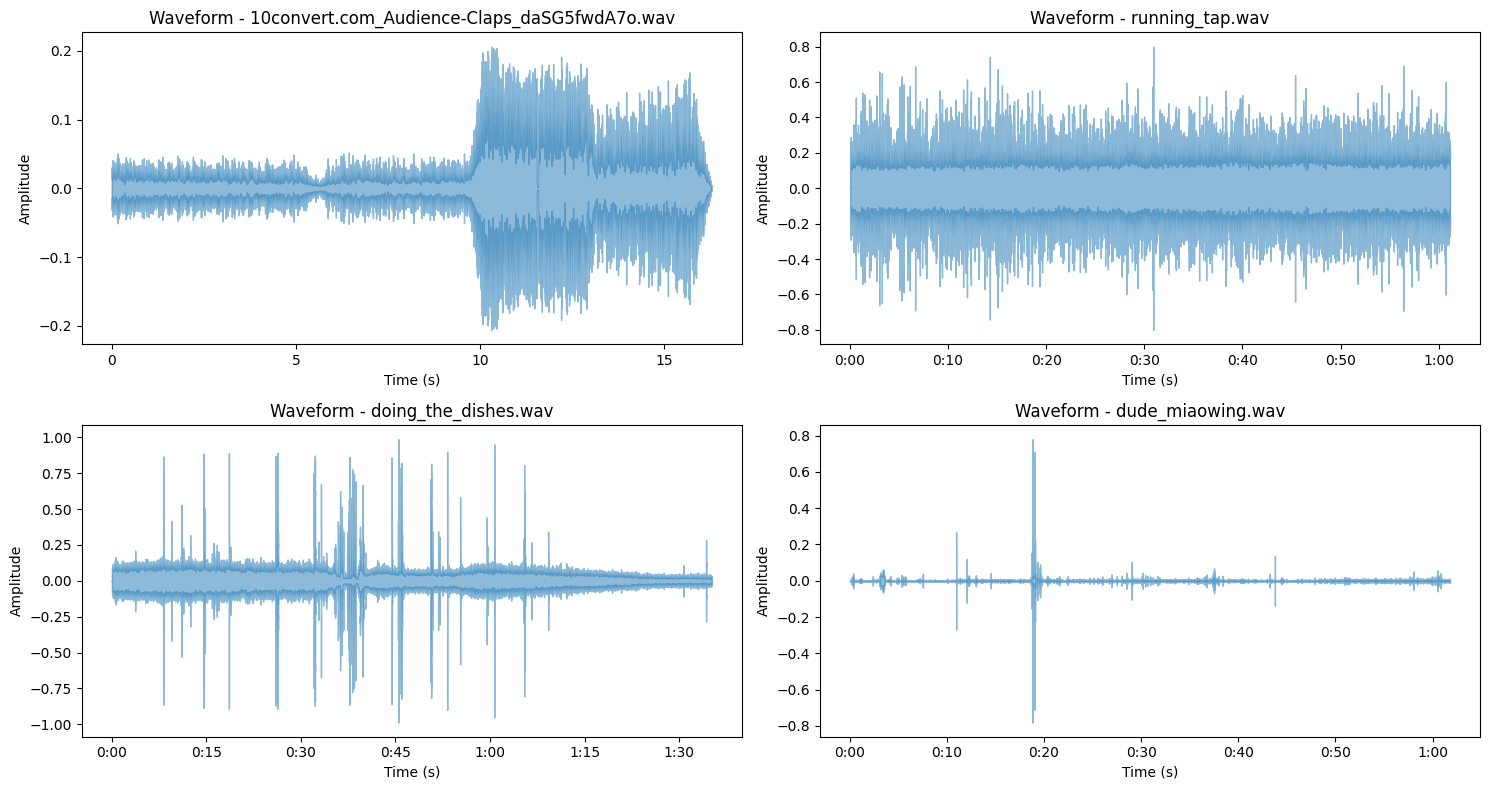

In [7]:
nelson_mandela_paths = plot("/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/_background_noise_")


##  Process training dataset


In [8]:
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [9]:
nelson_mandela_paths = get_wav_paths("Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths("Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths("Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( 'Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths("Julia_Gillard")

In [10]:
import tensorflow as tf

def load_wav(wav_path, speaker):
    wav_path = data_dir + speaker + "/" + wav_path
    
    wav_data, _ = tf.audio.decode_wav(tf.io.read_file(wav_path), desired_channels=1)
    wav_data = tf.reshape(wav_data, [1, -1])
    return wav_data



# Additive White Gaussian Noise (AWGN)

In [11]:
def add_awgn(signal, snr_dB):
    # Calculate noise power
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / (10 ** (snr_dB / 10.0))
    
    # Generate Gaussian noise
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    
    # Add noise to the signal
    noisy_signal = signal + noise
    return noisy_signal

In [12]:
def generate_training_data(speaker_paths, speaker, label, snr_dB=15):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        # Add AWGN to the waveform
        noisy_wav = add_awgn(wav, snr_dB)
        wavs.append(noisy_wav)
        labels.append(label)
    return wavs, labels

In [13]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, "Nelson_Mandela", 0) 
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, "Magaret_Tarcher", 1) 
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, "Benjamin_Netanyau", 2) 
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, "Jens_Stoltenberg", 3) 
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, "Julia_Gillard", 4) 

100%|██████████| 1501/1501 [00:10<00:00, 148.64it/s]


In [14]:
# remove the extra wav for Julia Gillard
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]

In [15]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels

In [16]:
train_wavs, test_wavs, train_labels, test_labels = train_test_split(all_wavs, all_labels, test_size=0.2)
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)

In [17]:
test_x.shape

(1500, 1, 16000)

In [18]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [19]:
!pip install spela
from spela.spectrogram import Spectrogram 
from spela.melspectrogram import Melspectrogram

In [20]:
def create_model(speech_feature):
    model = tf.keras.Sequential()
    if speech_feature == "spectrogram":
        model.add(Spectrogram(input_shape=(1, 16000)))
    elif speech_feature == "melspectrogram":
         model.add(Melspectrogram(input_shape=(1, 16000), name='melgram'))

    model.add(tf.keras.layers.Conv2D(265, (3, 3), activation="relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4)
            , loss = "categorical_crossentropy"
            , metrics = ["accuracy"])
    return model

In [21]:
model = create_model("spectrogram")

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectrogram (Spectrogram)   (None, 257, 63, 1)        263168    
                                                                 
 conv2d (Conv2D)             (None, 255, 61, 265)      2650      
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 20, 265)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 450500)            0         
                                                                 
 dense (Dense)               (None, 5)                 2252505   
                                                                 
Total params: 2518323 (9.61 MB)
Trainable params: 2518323 (9.61 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [23]:
history=model.fit(x=train_x, y=train_y, epochs=20, validation_data=(test_x, test_y))


Epoch 1/20
188/188 [==============================] - 18s 48ms/step - loss: 21.9044 - accuracy: 0.7167 - val_loss: 0.3748 - val_accuracy: 0.8480
Epoch 2/20
188/188 [==============================] - 8s 40ms/step - loss: 0.1752 - accuracy: 0.9317 - val_loss: 0.2741 - val_accuracy: 0.9013
Epoch 3/20
188/188 [==============================] - 8s 40ms/step - loss: 0.0909 - accuracy: 0.9648 - val_loss: 0.2405 - val_accuracy: 0.9093
Epoch 4/20
188/188 [==============================] - 8s 40ms/step - loss: 0.0639 - accuracy: 0.9770 - val_loss: 0.2439 - val_accuracy: 0.9213
Epoch 5/20
188/188 [==============================] - 8s 40ms/step - loss: 0.0521 - accuracy: 0.9785 - val_loss: 0.2614 - val_accuracy: 0.9267
Epoch 6/20
188/188 [==============================] - 8s 40ms/step - loss: 0.0397 - accuracy: 0.9872 - val_loss: 0.3388 - val_accuracy: 0.9100
Epoch 7/20
188/188 [==============================] - 8s 40ms/step - loss: 0.0721 - accuracy: 0.9772 - val_loss: 0.3513 - val_accuracy: 0.90

In [24]:
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"loss: {test_loss:0.3}\t accuracy: {test_accuracy:0.1%}")

47/47 [==============================] - 1s 11ms/step - loss: 0.6357 - accuracy: 0.9220
loss: 0.636	 accuracy: 92.2%


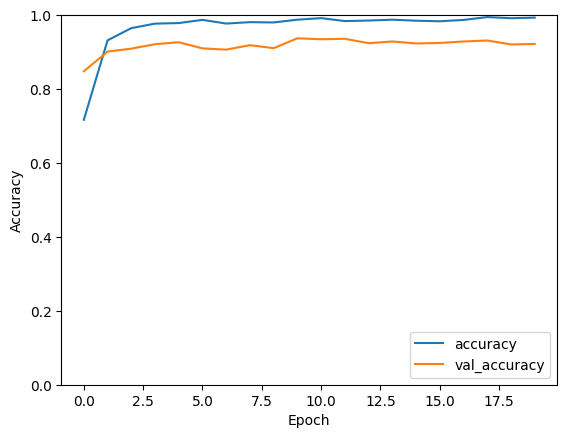

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right');

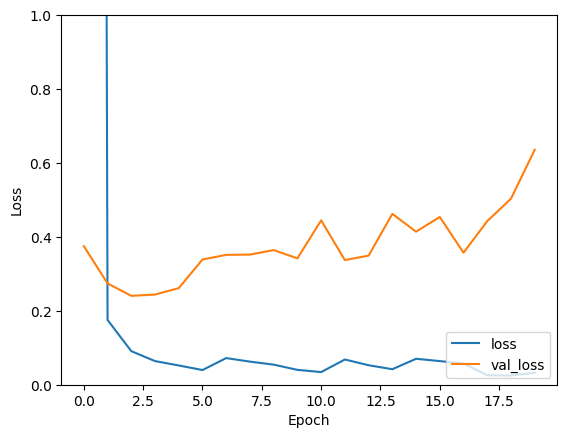

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show();

# Test the predication

In [27]:
train_x.shape

(6000, 1, 16000)

In [28]:
y_predication = model.predict(test_x)

47/47 [==============================] - 1s 10ms/step


In [29]:
y_predication[0]

array([6.607917e-36, 9.895563e-14, 3.563946e-06, 9.999964e-01,
       3.949620e-11], dtype=float32)

In [30]:
predicted_label = np.argmax(y_predication[0])

In [31]:
predicted_label

3

In [32]:
test_x[10]

array([[-0.18729289, -0.45566446, -0.48981363, ..., -0.02054484,
        -0.04581339, -0.04917032]], dtype=float32)

In [33]:
y_pred=[]
for  i in range(10):
    y_predication = model.predict(test_x)
    predicted_label = np.argmax(y_predication[i])
    y_pred.append(predicted_label)    

47/47 [==============================] - 0s 10ms/step


In [34]:
labels = np.argmax(test_y, axis=1)
pd.Series(labels)

0       3
1       1
2       4
3       0
4       2
       ..
1495    4
1496    1
1497    2
1498    4
1499    1
Length: 1500, dtype: int64

In [35]:
class_names = {0: "Nelson_Mandela", 1: "Magaret_Tarcher", 3: "Jens_Stoltenberg", 2: "Benjamin_Netanyau",4:'Julia_Gillard'}

for index in range(6):
        print(y_pred[index],
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] ==y_pred[index]:
            print("Welcome")
        else:
            print("Sorry")
        print("The speaker is" if labels[index] == y_pred[index] else "", class_names[y_pred[index]])

3 Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg
Welcome
The speaker is Jens_Stoltenberg
1 Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher
Welcome
The speaker is Magaret_Tarcher
4 Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
The speaker is Julia_Gillard
0 Speaker: Nelson_Mandela	Predicted: Nelson_Mandela
Welcome
The speaker is Nelson_Mandela
1 Speaker: Benjamin_Netanyau	Predicted: Magaret_Tarcher
Sorry
 Magaret_Tarcher
4 Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
The speaker is Julia_Gillard


# Inference 

In [36]:
from pydub import AudioSegment
def convert_mp3_to_wav(input_path, output_path):
    audio = AudioSegment.from_mp3(input_path)
    audio.export(output_path, format="wav")



In [37]:
input_path2 = "/kaggle/input/test-1/Voicy_Straight forward negotiating.mp3"
output_path2 = "/kaggle/working/output2.wav"
input_path3 = "/kaggle/input/test-1/Voicy_They have a cleverness .mp3"
output_path3 = "/kaggle/working/output3.wav"

In [38]:
convert_mp3_to_wav(input_path2, output_path2)


In [39]:
convert_mp3_to_wav(input_path3, output_path3)

In [40]:
import tensorflow as tf
import numpy as np

audio_arrays = []

file_paths = ["/kaggle/working/output2.wav", "/kaggle/working/output3.wav"]

for file_path in file_paths:
    wav_data, _ = tf.audio.decode_wav(tf.io.read_file(file_path), desired_channels=1, desired_samples=16000)
    reshaped_array = tf.reshape(wav_data, [1, 1, 16000])
    reshaped_array=add_awgn(reshaped_array,15)
    audio_arrays.append(reshaped_array)
audio_data_array = np.concatenate(audio_arrays, axis=0)

print("Shape of the resulting array:", audio_data_array.shape)

        

Shape of the resulting array: (2, 1, 16000)


In [41]:
audio_data_array.shape

(2, 1, 16000)

In [42]:
y_pred=[]
for  i in range(2):
    y_predication = model.predict(test_x)
    predicted_label = np.argmax(y_predication[i])
    y_pred.append(predicted_label)
    print(class_names[y_pred[i]])

47/47 [==============================] - 0s 10ms/step
Jens_Stoltenberg
47/47 [==============================] - 0s 10ms/step
Magaret_Tarcher


# With out Gaussian Noise

In [43]:
import tensorflow as tf
import numpy as np

audio_arrays = []

file_paths = ["/kaggle/working/output2.wav", "/kaggle/working/output3.wav"]

for file_path in file_paths:
    wav_data, _ = tf.audio.decode_wav(tf.io.read_file(file_path), desired_channels=1, desired_samples=16000)
    reshaped_array = tf.reshape(wav_data, [1, 1, 16000])
#     reshaped_array=add_awgn(reshaped_array,15)
    audio_arrays.append(reshaped_array)
audio_data_array = np.concatenate(audio_arrays, axis=0)

print("Shape of the resulting array:", audio_data_array.shape)

Shape of the resulting array: (2, 1, 16000)


In [44]:
y_pred=[]
for  i in range(2):
    y_predication = model.predict(test_x)
    predicted_label = np.argmax(y_predication[i])
    y_pred.append(predicted_label)
    print(class_names[y_pred[i]])

47/47 [==============================] - 0s 10ms/step
Jens_Stoltenberg
47/47 [==============================] - 0s 10ms/step
Magaret_Tarcher
